<a href="https://colab.research.google.com/github/CueSpaceFruit/vic_crash_classifier/blob/main/Classsifing_VIC_crash_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Processing of Big Data
# Machine Learning Pipeline

## Predicting Traffic Accident Severity Through Machine Learning on Victorian Accident Data

The original data has been downloaded from the Victorian Government on Traffic Accidents between 2006 and 2020
Link  https://discover.data.vic.gov.au/dataset/crash-stats-data-extract

The wrangled dataset can be found in following link

/content/drive/MyDrive/Colab Notebooks/AccidentFinal.csv

This wrangled dataset constitutes the starting point for the jupyter notebook application



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Create the Spark Session

In [ ]:
# Import SparkConf class into program
from pyspark import SparkConf

# local[*]: run Spark in local mode with as many working processors as logical cores on your machine
# If we want Spark to run locally with 'k' worker threads, we can specify as "local[k]".
master = "local[*]"
# The `appName` field is a name to be shown on the Spark cluster UI page
app_name = "Phase 3"
# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)

# Import SparkContext and SparkSession classes
from pyspark     import SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# Method 1: Using SparkSession
spark = SparkSession.builder.config(conf=spark_conf).getOrCreate()
sc = spark.sparkContext
sc.setLogLevel('ERROR')

# # Method 2: Getting or instantiating a SparkContext
# sc = SparkContext.getOrCreate(spark_conf)
# sc.setLogLevel('ERROR')

## Display our Spark Context Information
sc.uiWebUrl

'http://10.0.2.15:4040'

### Load Libraries

In [ ]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml         import Pipeline

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import NaiveBayes

from pyspark.sql           import functions as F
from pyspark.sql.functions import udf
from pyspark.sql.types     import NumericType
import numpy as np
import matplotlib.pyplot as plt

### Load Data from Phase 2

In [ ]:
# Read in the accident data as dataframe
AccidentFinal = spark.read.format('csv')\
                     .option('header',True)\
                     .option('escape','"')\
                     .option('inferSchema',True)\
                     .load('AccidentFinal.csv')

In [ ]:
# Print the Schema
AccidentFinal.printSchema()

root
 |-- accidentDate: string (nullable = true)
 |-- accidentTime: string (nullable = true)
 |-- accidentTypeDesc: string (nullable = true)
 |-- dayOfWeekDesc: string (nullable = true)
 |-- DCACode: integer (nullable = true)
 |-- DCADescription: string (nullable = true)
 |-- lightConditionDesc: string (nullable = true)
 |-- numVehicles: integer (nullable = true)
 |-- numPersons: integer (nullable = true)
 |-- numPersonsInj2: integer (nullable = true)
 |-- numPersonsInj3: integer (nullable = true)
 |-- numPersonsKilled: integer (nullable = true)
 |-- numPersonsNotInj: integer (nullable = true)
 |-- roadGeometryDesc: string (nullable = true)
 |-- accidentSeverity: integer (nullable = true)
 |-- speedZone: integer (nullable = true)
 |-- accidentDateOnly: string (nullable = true)
 |-- accidentTimeOnly: string (nullable = true)
 |-- accidentDateTime: string (nullable = true)
 |-- accidentSeverityDesc: string (nullable = true)
 |-- speedZoneDesc: string (nullable = true)
 |-- eventTypeDesc:

In [ ]:
#Check the shape of the dataframe
print((AccidentFinal.count(), len(AccidentFinal.columns)))

(775126, 54)


There are 775126 rows and 54 columns

In [ ]:
#Remove rows with Null value
AccidentFinal = AccidentFinal.na.drop()

### Add a binary label to classify severity rate

Based on the Data Dictionary Class 1 and 2 are Fatal and Severe Accidents.  We are going to use severity rate as our target variable.

In [ ]:
# Transform target variable into binary form. 1 if there was a severe accident, 0 if not

# Create function to convert target variable
y_udf = udf(lambda y: 1 if y == '1' or y == '2' else 0)

# Apply user defined function and drop old column
AccidentFinal = AccidentFinal.withColumn('severeAccident', y_udf('maxInjuryLevel')).drop('maxInjuryLevel')

There are some columns that are unlikely to contribute to the model. We are looking for variables that do not describe the events of the accident specifically as they cannot be changed and also will not be independent. We also want to drop variables that are related to each other. These were the columns that were dropped:
* DCA Code - this aligns with the accident type description so can be dropped
* DCA Description - this contains similar info to accident type description so can be dropped
* Number of persons injured/killed - this contains the similar information as 'max injury level' where we have tracked the most severe accident level relative to a certain accident
* Number of vehicles - since this variable only occurs at the accident, it is not relevant in prediction
* Driver age - we will use age groups instead
* Number of occupants - not relevant to analysis and hard to compare across vehicles of different sizes
* Vehicle movement - also another variable that is only relevant when accident occurs, hence not relevant for prediction
* Fuel type - assume that this does not play a large part in accidents
* Node type description and road geometry description are similar, so we will drop node type desc.
* Level of damage - only relevant after accident occurs, not relevant for our model
* Postcode, Region - we can use Local Goverment Area (LGA) name to get location information.

In [ ]:
## Dropping Columns that are unlikely to contribute to the model
AccidentFinal = AccidentFinal.drop('accidentDate','accidentTime', 'DCACode', 'numVehicles',
                                   'numPersons','numPersonsInj2', 'numPersonsInj3', "speedZone",
                                   'numPersonsKilled', 'numPersonsNotInj', 'accidentDateOnly', 'accidentTimeOnly',
                                   'accidentDateTime', 'roadSurfaceType', 'driverAge', 'trafficControl', 'vehicleType',
                                   'fuelType','traffic Control','regionName','postCode','nodeTypeDesc',
                                   'accidentSeverityDesc', 'accidentSeverity', 'totalNoOccupants', 'DCADescription',
                                  'isPedestrian', 'vehicleMovement', 'eventTypeDesc', 'accidentTypeDesc',
                                   'levelOfDamage',
                                  )

In [ ]:
#Print the schema with selected columns
AccidentFinal.printSchema()
AccidentFinal.show(1, vertical = True)

root
 |-- dayOfWeekDesc: string (nullable = true)
 |-- lightConditionDesc: string (nullable = true)
 |-- roadGeometryDesc: string (nullable = true)
 |-- speedZoneDesc: string (nullable = true)
 |-- dust: double (nullable = true)
 |-- fog: double (nullable = true)
 |-- raining: double (nullable = true)
 |-- smoke: double (nullable = true)
 |-- snowing: double (nullable = true)
 |-- strongWinds: double (nullable = true)
 |-- icy: double (nullable = true)
 |-- muddy: double (nullable = true)
 |-- snowy: double (nullable = true)
 |-- wet: double (nullable = true)
 |-- dry: double (nullable = true)
 |-- clear: double (nullable = true)
 |-- vehicleYearManuf: double (nullable = true)
 |-- roadSurfaceTypeDesc: string (nullable = true)
 |-- vehicleTypeDesc: string (nullable = true)
 |-- trafficControlDesc: string (nullable = true)
 |-- driverSex: string (nullable = true)
 |-- driverAgeGroup: string (nullable = true)
 |-- LGAName: string (nullable = true)
 |-- severeAccident: string (nullable = 

In [ ]:
#Check the shape of the dataframe
print((AccidentFinal.count(), len(AccidentFinal.columns)))

(690805, 24)


In [ ]:
# Check the split of labels
AccidentFinal.groupBy('severeAccident').count().show()

+--------------+------+
|severeAccident| count|
+--------------+------+
|             0|577416|
|             1|113389|
+--------------+------+



In [ ]:
# Sample the data such that our Severe and Non-Sever Accidents are similar sizes

sample_1 , sample_2 = AccidentFinal.filter(AccidentFinal.severeAccident == '0').randomSplit([0.8, 0.2], seed = 42)

In [ ]:
# Union the two dataframes back together to create one dataset
AccidentFinal = AccidentFinal.filter(AccidentFinal.severeAccident == '1')
AccidentFinal = AccidentFinal.union(sample_2)

In [ ]:
# Records in final dataframe
AccidentFinal.count()

229131

# Feature Engineering

In [ ]:
AccidentFinal.printSchema()

root
 |-- dayOfWeekDesc: string (nullable = true)
 |-- lightConditionDesc: string (nullable = true)
 |-- roadGeometryDesc: string (nullable = true)
 |-- speedZoneDesc: string (nullable = true)
 |-- dust: double (nullable = true)
 |-- fog: double (nullable = true)
 |-- raining: double (nullable = true)
 |-- smoke: double (nullable = true)
 |-- snowing: double (nullable = true)
 |-- strongWinds: double (nullable = true)
 |-- icy: double (nullable = true)
 |-- muddy: double (nullable = true)
 |-- snowy: double (nullable = true)
 |-- wet: double (nullable = true)
 |-- dry: double (nullable = true)
 |-- clear: double (nullable = true)
 |-- vehicleYearManuf: double (nullable = true)
 |-- roadSurfaceTypeDesc: string (nullable = true)
 |-- vehicleTypeDesc: string (nullable = true)
 |-- trafficControlDesc: string (nullable = true)
 |-- driverSex: string (nullable = true)
 |-- driverAgeGroup: string (nullable = true)
 |-- LGAName: string (nullable = true)
 |-- severeAccident: string (nullable = 

In [ ]:
# Change data type as the variables below are Double wheen they should actaully be interger values

AccidentFinal = AccidentFinal.withColumn ("dust", AccidentFinal.dust.cast("Int"))\
                             .withColumn ("fog", AccidentFinal.fog.cast("Int") )\
                             .withColumn ("raining", AccidentFinal.raining.cast("Int") )\
                             .withColumn ("smoke", AccidentFinal.smoke.cast("Int") )\
                             .withColumn ("snowing", AccidentFinal.snowing.cast("Int") )\
                             .withColumn ("strongWinds", AccidentFinal. strongWinds.cast("Int") ) \
                             .withColumn ("icy", AccidentFinal.icy.cast("Int") )\
                             .withColumn ("muddy", AccidentFinal.muddy.cast("Int") )\
                             .withColumn ("snowy", AccidentFinal.snowy.cast("Int") )  \
                             .withColumn ("wet", AccidentFinal.wet.cast("Int") )\
                             .withColumn ("dry", AccidentFinal.dry.cast("Int") ) \
                             .withColumn ("clear", AccidentFinal.clear.cast("Int") )\
                             .withColumn ("vehicleYearManuf", AccidentFinal.vehicleYearManuf.cast("Int") )\
                             .withColumn ("severeAccident", AccidentFinal.severeAccident.cast("Int"))\
                             .cache()

In [ ]:
# First, save the category in the category columns list.
# Split categorical and numeric variables. Make sure our target variable is not included in the listing

categoryInputCols   = [item[0] for item in AccidentFinal.dtypes if     item[1].startswith('string') and item[0] != 'severeAccident']
numericalInputCols  = [item[0] for item in AccidentFinal.dtypes if not item[1].startswith('string') and item[0] != 'severeAccident']
outputCol           = 'severeAccident'
categoryCols        = categoryInputCols + [outputCol]

In [ ]:
### Convert categorical columns
from pyspark.ml.feature import StringIndexer

# Define the output columns
outputCols = [f'{x}_index' for x in categoryInputCols]
outputCols.append('label')

# View input and output column names
print(categoryCols)
print(outputCols)
print(numericalInputCols)


['dayOfWeekDesc', 'lightConditionDesc', 'roadGeometryDesc', 'speedZoneDesc', 'roadSurfaceTypeDesc', 'vehicleTypeDesc', 'trafficControlDesc', 'driverSex', 'driverAgeGroup', 'LGAName', 'severeAccident']
['dayOfWeekDesc_index', 'lightConditionDesc_index', 'roadGeometryDesc_index', 'speedZoneDesc_index', 'roadSurfaceTypeDesc_index', 'vehicleTypeDesc_index', 'trafficControlDesc_index', 'driverSex_index', 'driverAgeGroup_index', 'LGAName_index', 'label']
['dust', 'fog', 'raining', 'smoke', 'snowing', 'strongWinds', 'icy', 'muddy', 'snowy', 'wet', 'dry', 'clear', 'vehicleYearManuf']


In [ ]:
### Create the index values for categorical values
# Initialize StringIndexer (use inputCols and outputCols)
inputIndexer = StringIndexer(inputCols = categoryCols, outputCols = outputCols, handleInvalid = 'keep')

# Call the fit and transform() method to get the encoded results
df_indexed = inputIndexer.fit(AccidentFinal).transform(AccidentFinal)

# Display the output, only the output columns
df_indexed.select(outputCols).show()

+-------------------+------------------------+----------------------+-------------------+-------------------------+---------------------+------------------------+---------------+--------------------+-------------+-----+
|dayOfWeekDesc_index|lightConditionDesc_index|roadGeometryDesc_index|speedZoneDesc_index|roadSurfaceTypeDesc_index|vehicleTypeDesc_index|trafficControlDesc_index|driverSex_index|driverAgeGroup_index|LGAName_index|label|
+-------------------+------------------------+----------------------+-------------------+-------------------------+---------------------+------------------------+---------------+--------------------+-------------+-----+
|                5.0|                     0.0|                   1.0|                1.0|                      0.0|                  1.0|                     0.0|            0.0|                 1.0|         14.0|  1.0|
|                5.0|                     0.0|                   1.0|                1.0|                      0.0|     

In [ ]:
from pyspark.ml.feature import OneHotEncoder

# input columns for OHE are all output columns from StringIndexer except label
inputCols_OHE  = [x for x in outputCols if x!='label']
outputCols_OHE = [f'{x}_vec' for x in categoryInputCols]

# Define OneHotEncoder with the appropriate columns
encoder = OneHotEncoder(inputCols  = inputCols_OHE, outputCols = outputCols_OHE)

model = encoder.fit(df_indexed)
# Call fit and transform to get the encoded results
df_encoded = model.transform(df_indexed)
# Display the output columns
df_encoded.select(outputCols_OHE).show()

+-----------------+----------------------+--------------------+-----------------+-----------------------+-------------------+----------------------+-------------+------------------+---------------+
|dayOfWeekDesc_vec|lightConditionDesc_vec|roadGeometryDesc_vec|speedZoneDesc_vec|roadSurfaceTypeDesc_vec|vehicleTypeDesc_vec|trafficControlDesc_vec|driverSex_vec|driverAgeGroup_vec|    LGAName_vec|
+-----------------+----------------------+--------------------+-----------------+-----------------------+-------------------+----------------------+-------------+------------------+---------------+
|    (7,[5],[1.0])|         (7,[0],[1.0])|       (9,[1],[1.0])|   (13,[1],[1.0])|          (4,[0],[1.0])|     (21,[1],[1.0])|        (17,[0],[1.0])|(3,[0],[1.0])|    (13,[1],[1.0])|(88,[14],[1.0])|
|    (7,[5],[1.0])|         (7,[0],[1.0])|       (9,[1],[1.0])|   (13,[1],[1.0])|          (4,[0],[1.0])|     (21,[1],[1.0])|        (17,[0],[1.0])|(3,[0],[1.0])|    (13,[1],[1.0])|(88,[14],[1.0])|
|    (7,[0

In [ ]:
from pyspark.ml.feature import VectorAssembler

# inputCols are all the encoded columns from OHE plus numerical columns
inputCols       = outputCols_OHE
assemblerInputs = outputCols_OHE + numericalInputCols

# Define the assembler with appropriate input and output columns
assembler = VectorAssembler(inputCols = assemblerInputs, outputCol = "features")

# use the assembler transform() to get encoded results
df_final = assembler.transform(df_encoded)
# Display the output
df_final.select('features').show()

+--------------------+
|            features|
+--------------------+
|(195,[5,7,15,24,3...|
|(195,[5,7,15,24,3...|
|(195,[0,8,14,24,3...|
|(195,[0,8,14,24,3...|
|(195,[1,7,16,24,3...|
|(195,[1,7,16,24,3...|
|(195,[1,7,16,24,3...|
|(195,[6,7,15,23,3...|
|(195,[6,7,15,23,3...|
|(195,[3,9,14,23,3...|
|(195,[0,7,15,24,3...|
|(195,[2,7,14,25,3...|
|(195,[2,7,14,25,3...|
|(195,[5,8,15,26,3...|
|(195,[5,8,15,26,3...|
|(195,[5,8,15,26,3...|
|(195,[1,7,14,31,3...|
|(195,[6,8,15,24,3...|
|(195,[6,8,15,24,3...|
|(195,[6,8,15,24,3...|
+--------------------+
only showing top 20 rows



### Pipeline API <a class="anchor" name="pipeline"></a>

In [ ]:
# Pipelines and PipelineModels help to ensure that training and test data go through identical
# feature processing steps.

stage_1 = inputIndexer
stage_2 = encoder
stage_3 = assembler

stages = [stage_1,stage_2,stage_3]

pipeline      = Pipeline(stages = stages)
pipelineModel = pipeline.fit(AccidentFinal)
df_pipeline   = pipelineModel.transform(AccidentFinal)

#Choose only label and features to create a dataframe
selectedCols = ['label', 'features'] + AccidentFinal.columns
df_pipeline  = df_pipeline.select(selectedCols)
df_pipeline.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- dayOfWeekDesc: string (nullable = true)
 |-- lightConditionDesc: string (nullable = true)
 |-- roadGeometryDesc: string (nullable = true)
 |-- speedZoneDesc: string (nullable = true)
 |-- dust: integer (nullable = true)
 |-- fog: integer (nullable = true)
 |-- raining: integer (nullable = true)
 |-- smoke: integer (nullable = true)
 |-- snowing: integer (nullable = true)
 |-- strongWinds: integer (nullable = true)
 |-- icy: integer (nullable = true)
 |-- muddy: integer (nullable = true)
 |-- snowy: integer (nullable = true)
 |-- wet: integer (nullable = true)
 |-- dry: integer (nullable = true)
 |-- clear: integer (nullable = true)
 |-- vehicleYearManuf: integer (nullable = true)
 |-- roadSurfaceTypeDesc: string (nullable = true)
 |-- vehicleTypeDesc: string (nullable = true)
 |-- trafficControlDesc: string (nullable = true)
 |-- driverSex: string (nullable = true)
 |-- driverAgeGroup: string (nulla

###  Train/Test Split <a class="anchor" name="train-test"></a>

In [ ]:
# Divide data into train sets and test sets
train, test = df_pipeline.randomSplit([0.8, 0.2], seed = 2020)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count    : " + str(test.count()))

Training Dataset Count: 183117
Test Dataset Count    : 46014


In [ ]:
## Add Training Dataset to memory
train = train.cache()

### Run Logistic Regression Model

In [ ]:
# Create a logistic model using the train set.
lr = LogisticRegression(featuresCol = 'features', labelCol = 'label')
lrModel = lr.fit(train)

In [ ]:
# Predict using logistic regression model on test data
lrPredictions = lrModel.transform(test)
lrPredictions.select('features','label','prediction','probability').show()

+--------------------+-----+----------+--------------------+
|            features|label|prediction|         probability|
+--------------------+-----+----------+--------------------+
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.62094281393110...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.61712098226159...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.50182500396728...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.65397122440126...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.65397122440126...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.54031675781631...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.58251152482309...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.61422290101123...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.58684317909735...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.54997023911511...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.54997023911511...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.60646189989814...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.55646328394103...|
|(195,[0,7,14,23,3...|  

### Random Forest Model

In [ ]:
# Create a Random Forest Classification model and train it
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', seed=2020)
rfModel = rf.fit(train)

In [ ]:
# Predict using test data
rfPredictions = rfModel.transform(test)
rfPredictions.select('features','label','prediction','probability').show()

+--------------------+-----+----------+--------------------+
|            features|label|prediction|         probability|
+--------------------+-----+----------+--------------------+
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.50854753455757...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.50854753455757...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.52476405104951...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.50854753455757...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.50854753455757...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.52519521071331...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.52869842099125...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.50535880720912...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.52041226047563...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.50392308452929...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.50392308452929...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.50392308452929...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.50392308452929...|
|(195,[0,7,14,23,3...|  

### Decision Tree

In [ ]:
# Extracts the number of nodes in the decision tree and the tree depth in the model and stores it in dt.
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label')
dtModel = dt.fit(train)

In [ ]:
# Predict using test data
dtPredictions = dtModel.transform(test)
dtPredictions.select('features','label','prediction','probability').show()

+--------------------+-----+----------+--------------------+
|            features|label|prediction|         probability|
+--------------------+-----+----------+--------------------+
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.55061715980793...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.55061715980793...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.66466314532612...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.55061715980793...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.55061715980793...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.66466314532612...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.66466314532612...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.55061715980793...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.66466314532612...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.55061715980793...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.55061715980793...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.55061715980793...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.55061715980793...|
|(195,[0,7,14,23,3...|  

### Naive Bayes Model

In [ ]:
# Train Naive Bayes model
nb = NaiveBayes(labelCol = "label", featuresCol = "features")
nbModel = nb.fit(train)

In [ ]:
# Predict using test data
nbPredictions = nbModel.transform(test)
nbPredictions.select('features','label','prediction','probability').show()

+--------------------+-----+----------+--------------------+
|            features|label|prediction|         probability|
+--------------------+-----+----------+--------------------+
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.61548562369771...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.61421815265282...|
|(195,[0,7,14,23,3...|  1.0|       1.0|[0.47035165976647...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.67291793464969...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.67291793464969...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.55435679515054...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.59129449437268...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.61437085879589...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.57759097303604...|
|(195,[0,7,14,23,3...|  1.0|       1.0|[0.47501712902170...|
|(195,[0,7,14,23,3...|  1.0|       1.0|[0.47501712902170...|
|(195,[0,7,14,23,3...|  1.0|       0.0|[0.52291282904112...|
|(195,[0,7,14,23,3...|  1.0|       1.0|[0.43568252622063...|
|(195,[0,7,14,23,3...|  

In [ ]:
#Drop Training Set from memory
#train.unpersist()

## Model Evaluation
Lets evaluate the module using the Confusion matrix

In [ ]:
def compute_metrics(predictions):
    # Calculate the elements of the confusion matrix

    ## Select only the two columns we need and cache table
    metrics = predictions.select("label","prediction").cache()

    # do the calculations

    TN = metrics.filter('prediction = 0 AND label = 0').count()
    TP = metrics.filter('prediction = 1 AND label = 1').count()
    FN = metrics.filter('prediction = 0 AND label = 1').count()
    FP = metrics.filter('prediction = 1 AND label = 0').count()


    ## Remove table to clean up memory
    metrics.unpersist()

    # return error message if evaluation divides by zero
    if (TN + TP + FN + FP) == 0 or (TP + FP) == 0 or (TP + FN) == 0:
        return 'div by zero error - check model'

    # calculate metrics by the confusion matrix
    accuracy  = (TN + TP) / (TN + TP + FN + FP)
    precision = TP        / (TP + FP)
    recall    = TP        / (TP + FN)
    f1        = 2 / ( ( 1 / recall) + ( 1 / precision) )

    # Print metrics
    print('-------------------------')
    print('Predict    Label   Count')
    print('-------------------------')
    print(f'   0         0     { TN }')
    print(f'   1         1     { TP }')
    print(f'   0         1     { FN }')
    print(f'   1         0     { FP }')
    print('\n')
    print(f'Accuracy : {accuracy  :3.3}')
    print(f'Precision: {precision :3.3}')
    print(f'Recall   : {recall    :3.3}')
    print(f'F1       : {f1        :3.3}')

    return accuracy,precision,recall,f1

In [ ]:
%%time

%matplotlib inline

print('Logistic Regression Classifier')
lr_acc,lr_pr,lr_rec,lr_f1 = compute_metrics(lrPredictions)

print('\nRandom Forest Classifier')
rf_acc,rf_pr,rf_rec,rf_f1 = compute_metrics(rfPredictions)

print('\nDecision Tree Classifier')
dt_acc,dt_pr,dt_rec,dt_f1 = compute_metrics(dtPredictions)

print('\nNaive Bayes Classifier')
nb_acc,nb_pr,nb_rec,nb_f1 = compute_metrics(nbPredictions)

Logistic Regression Classifier
-------------------------
Predict    Label   Count
-------------------------
   0         0     15745
   1         1     13704
   0         1     9071
   1         0     7494


Accuracy : 0.64
Precision: 0.646
Recall   : 0.602
F1       : 0.623

Random Forest Classifier
-------------------------
Predict    Label   Count
-------------------------
   0         0     15990
   1         1     12931
   0         1     9844
   1         0     7249


Accuracy : 0.629
Precision: 0.641
Recall   : 0.568
F1       : 0.602

Decision Tree Classifier
-------------------------
Predict    Label   Count
-------------------------
   0         0     17530
   1         1     11134
   0         1     11641
   1         0     5709


Accuracy : 0.623
Precision: 0.661
Recall   : 0.489
F1       : 0.562

Naive Bayes Classifier
-------------------------
Predict    Label   Count
-------------------------
   0         0     15995
   1         1     12830
   0         1     9945
   1   

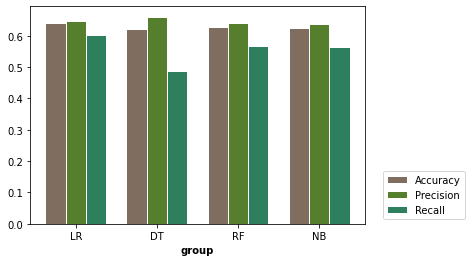

In [ ]:
## Let's graph these values
y_acc = [lr_acc,dt_acc,rf_acc,nb_acc]
y_pr  = [lr_pr,dt_pr,rf_pr,nb_pr]
y_rec = [lr_rec,dt_rec,rf_rec,nb_rec]

# set width of bar
barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(y_acc))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
plt.bar(r1, y_acc, color='#7f6d5f', width = barWidth, edgecolor = 'white', label = 'Accuracy')
plt.bar(r2, y_pr,  color='#557f2d', width = barWidth, edgecolor = 'white', label = 'Precision')
plt.bar(r3, y_rec, color='#2d7f5e', width = barWidth, edgecolor = 'white', label = 'Recall')

# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(y_acc))], ['LR', 'DT', 'RF', 'NB'])

# Create legend & Show graphic
plt.legend(bbox_to_anchor=(1.04,0), loc = 'lower left')
plt.show()


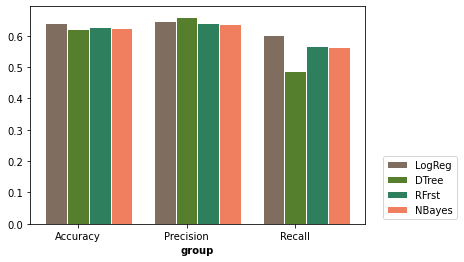

In [ ]:
## Alternative Graph the Data to compare like variables by different methods

lr_data = [lr_acc, lr_pr, lr_rec]
dt_data = [dt_acc, dt_pr, dt_rec]
rf_data = [rf_acc, rf_pr, rf_rec]
nb_data = [nb_acc, nb_pr, nb_rec]


# set width of bar
barWidth = 0.20

# Set position of bar on X axis
r1 = np.arange(len(lr_data))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

# Make the plot
plt.bar(r1, lr_data,  color = '#7f6d5f', width = barWidth, edgecolor = 'white', label = 'LogReg')
plt.bar(r2, dt_data,  color = '#557f2d', width = barWidth, edgecolor = 'white', label = 'DTree')
plt.bar(r3, rf_data,  color = '#2d7f5e', width = barWidth, edgecolor = 'white', label = 'RFrst')
plt.bar(r4, nb_data,  color = '#ef7f5e', width = barWidth, edgecolor = 'white', label = 'NBayes')

# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(lr_data))], ['Accuracy', 'Precision', 'Recall'])

# Create legend & Show graphic
plt.legend(bbox_to_anchor=(1.04,0), loc = 'lower left')
plt.show()

In [ ]:
%%time
# Use BinaryClassificationEvaluator to evaluate a model
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model Decision Tree
evaluator = BinaryClassificationEvaluator(rawPredictionCol = "rawPrediction")
auc_dt = evaluator.evaluate(dtPredictions)

print(f'AUC_DT       : {auc_dt :3.3}')
print('Decision Tree: ' + evaluator.getMetricName() + '\n')

auc_rf = evaluator.evaluate(rfPredictions)
print(f'AUC_RF       : {auc_rf :3.3}')
print('Random Forest: ' + evaluator.getMetricName() + '\n')

auc_lr = evaluator.evaluate(lrPredictions)
print(f'AUC_LR             : {auc_lr :3.3}')
print('Logistic Regression: ' + evaluator.getMetricName() + '\n')

auc_nb = evaluator.evaluate(nbPredictions)
print(f'AUC_NB     : {auc_nb:3.3}')
print('Naive Bayes: ' + evaluator.getMetricName() + '\n')

AUC_DT       : 0.408
Decision Tree: areaUnderROC

AUC_RF       : 0.676
Random Forest: areaUnderROC

AUC_LR             : 0.65
Logistic Regression: areaUnderROC

AUC_NB     : 0.526
Naive Bayes: areaUnderROC

CPU times: user 15.6 ms, sys: 3.88 ms, total: 19.5 ms
Wall time: 12.2 s


### Extract TPR/FPR for ROC plot

In [ ]:
# numpy for np.linspace function
import numpy as np

#User Defined Function to split the probabilities into two columns
import pyspark.sql.functions as F
import pyspark.sql.types     as T
to_array = F.udf(lambda v: v.toArray().tolist(), T.ArrayType(T.FloatType()))

#### Decision Tree TPR/FPR

In [ ]:
#Splitting the probability to 2 parts using the UDF
dtRocDf = dtPredictions.withColumn('probability', to_array('probability'))
dtRocDf

#A new df which contains the probabilites in separate columns
dtRocDf_prob = dtRocDf.select(dtRocDf.probability[0].alias('negative_prob'),dtRocDf.probability[1].alias('positive_prob'),'label')
dtRocDf_prob


DataFrame[negative_prob: float, positive_prob: float, label: double]

#### Random Forest TPR/FPR

In [ ]:
#Splitting the probability to 2 parts using the UDF
rfRocDf = rfPredictions.withColumn('probability', to_array('probability'))
rfRocDf

#A new df which contains the probabilites in separate columns
rfRocDf_prob = rfRocDf.select(rfRocDf.probability[0].alias('negative_prob'),rfRocDf.probability[1].alias('positive_prob'),'label')
rfRocDf_prob

DataFrame[negative_prob: float, positive_prob: float, label: double]

#### Naive Bayes TPR/FPR

In [ ]:
#Splitting the probability to 2 parts using the UDF
nbRocDf = nbPredictions.withColumn('probability', to_array('probability'))
nbRocDf

#A new df which contains the probabilites in separate columns
nbRocDf_prob = nbRocDf.select(nbRocDf.probability[0].alias('negative_prob'),nbRocDf.probability[1].alias('positive_prob'),'label')
nbRocDf_prob

DataFrame[negative_prob: float, positive_prob: float, label: double]

#### Linear Regression TPR/FPR

In [ ]:
#Splitting the probability to 2 parts using the UDF
lrRocDf = lrPredictions.withColumn('probability', to_array('probability'))
lrRocDf

#A new df which contains the probabilites in separate columns
lrRocDf_prob = lrRocDf.select(lrRocDf.probability[0].alias('negative_prob'),lrRocDf.probability[1].alias('positive_prob'),'label')
lrRocDf_prob

DataFrame[negative_prob: float, positive_prob: float, label: double]

In [ ]:
def confusion_matrix(predictions):
    # Calculate the elements of the confusion matrix

    metrics = predictions.select("label","prediction").cache()

    TN = metrics.filter('prediction = 0 AND label = 0').count()
    TP = metrics.filter('prediction = 1 AND label = 1').count()
    FN = metrics.filter('prediction = 0 AND label = 1').count()
    FP = metrics.filter('prediction = 1 AND label = 0').count()

    metrics.unpersist()

    return TP,TN,FP,FN

In [ ]:
#Create array of TPR/FPR values - Decision Tree
roc_values = []
for threshold in np.linspace(0, 1, 20):
        dtRocDf_prob = dtRocDf_prob.withColumn('prediction',F.when(dtRocDf_prob.positive_prob > threshold,1).otherwise(0))
        tp,tn,fp,fn  = confusion_matrix(dtRocDf_prob)
        tpr          = tp / (tp + fn)
        fpr          = fp / (fp + tn)

        print(f'Threshold : {threshold :6.6f}  TPR : { tpr :6.6f}  FPR : {fpr :6.6f} ')

        roc_values.append([tpr, fpr])
tpr_dt_values, fpr_dt_values = zip(*roc_values)

Threshold : 0.000000  TPR : 0.999956  FPR : 0.999957 
Threshold : 0.052632  TPR : 0.999956  FPR : 0.999957 
Threshold : 0.105263  TPR : 0.999956  FPR : 0.999957 
Threshold : 0.157895  TPR : 0.999912  FPR : 0.999742 
Threshold : 0.210526  TPR : 0.999912  FPR : 0.999742 
Threshold : 0.263158  TPR : 0.998727  FPR : 0.996730 
Threshold : 0.315789  TPR : 0.998727  FPR : 0.996730 
Threshold : 0.368421  TPR : 0.819012  FPR : 0.639657 
Threshold : 0.421053  TPR : 0.818793  FPR : 0.639399 
Threshold : 0.473684  TPR : 0.516048  FPR : 0.274108 
Threshold : 0.526316  TPR : 0.488869  FPR : 0.245665 
Threshold : 0.578947  TPR : 0.439341  FPR : 0.203537 
Threshold : 0.631579  TPR : 0.435785  FPR : 0.200826 
Threshold : 0.684211  TPR : 0.080088  FPR : 0.019622 
Threshold : 0.736842  TPR : 0.066345  FPR : 0.012866 
Threshold : 0.789474  TPR : 0.049967  FPR : 0.008692 
Threshold : 0.842105  TPR : 0.015456  FPR : 0.002281 
Threshold : 0.894737  TPR : 0.000000  FPR : 0.000000 
Threshold : 0.947368  TPR : 

In [ ]:
#Create array of TPR/FPR values - Random Forrest
rfRoc_values = []
for threshold in np.linspace(0, 1, 20):
        rfRocDf_prob = rfRocDf_prob.withColumn('prediction',F.when(rfRocDf_prob.positive_prob > threshold,1).otherwise(0))
        tp,tn,fp,fn  = confusion_matrix(rfRocDf_prob)
        tpr          = tp / (tp + fn)
        fpr          = fp / (fp + tn)

        print(f'Threshold : {threshold :6.6f}  TPR : { tpr :6.6f}  FPR : {fpr :6.6f} ')

        rfRoc_values.append([tpr, fpr])
tpr_rf_values, fpr_rf_values = zip(*rfRoc_values)

Threshold : 0.000000  TPR : 1.000000  FPR : 1.000000 
Threshold : 0.052632  TPR : 1.000000  FPR : 1.000000 
Threshold : 0.105263  TPR : 1.000000  FPR : 1.000000 
Threshold : 0.157895  TPR : 1.000000  FPR : 1.000000 
Threshold : 0.210526  TPR : 1.000000  FPR : 1.000000 
Threshold : 0.263158  TPR : 1.000000  FPR : 1.000000 
Threshold : 0.315789  TPR : 1.000000  FPR : 1.000000 
Threshold : 0.368421  TPR : 0.999780  FPR : 0.998709 
Threshold : 0.421053  TPR : 0.959297  FPR : 0.876156 
Threshold : 0.473684  TPR : 0.744501  FPR : 0.502388 
Threshold : 0.526316  TPR : 0.406367  FPR : 0.179999 
Threshold : 0.578947  TPR : 0.106915  FPR : 0.028056 
Threshold : 0.631579  TPR : 0.010538  FPR : 0.001807 
Threshold : 0.684211  TPR : 0.000000  FPR : 0.000000 
Threshold : 0.736842  TPR : 0.000000  FPR : 0.000000 
Threshold : 0.789474  TPR : 0.000000  FPR : 0.000000 
Threshold : 0.842105  TPR : 0.000000  FPR : 0.000000 
Threshold : 0.894737  TPR : 0.000000  FPR : 0.000000 
Threshold : 0.947368  TPR : 

In [ ]:
#Create array of TPR/FPR values - Naive Bayes
nbRoc_values = []
for threshold in np.linspace(0, 1, 20):
        nbRocDf_prob = nbRocDf_prob.withColumn('prediction',F.when(nbRocDf_prob.positive_prob > threshold,1).otherwise(0))
        tp,tn,fp,fn  = confusion_matrix(nbRocDf_prob)
        tpr          = tp / (tp + fn)
        fpr          = fp / (fp + tn)

        print(f'Threshold : {threshold :6.6f}  TPR : { tpr :6.6f}  FPR : {fpr :6.6f} ')

        nbRoc_values.append([tpr, fpr])
tpr_nb_values, fpr_nb_values = zip(*nbRoc_values)

Threshold : 0.000000  TPR : 1.000000  FPR : 1.000000 
Threshold : 0.052632  TPR : 0.999780  FPR : 0.996299 
Threshold : 0.105263  TPR : 0.994951  FPR : 0.976376 
Threshold : 0.157895  TPR : 0.983008  FPR : 0.930419 
Threshold : 0.210526  TPR : 0.956487  FPR : 0.859202 
Threshold : 0.263158  TPR : 0.913106  FPR : 0.766169 
Threshold : 0.315789  TPR : 0.853172  FPR : 0.657429 
Threshold : 0.368421  TPR : 0.776948  FPR : 0.546452 
Threshold : 0.421053  TPR : 0.689791  FPR : 0.441026 
Threshold : 0.473684  TPR : 0.606586  FPR : 0.351177 
Threshold : 0.526316  TPR : 0.521493  FPR : 0.274754 
Threshold : 0.578947  TPR : 0.445928  FPR : 0.210379 
Threshold : 0.631579  TPR : 0.375499  FPR : 0.158441 
Threshold : 0.684211  TPR : 0.309989  FPR : 0.115237 
Threshold : 0.736842  TPR : 0.252909  FPR : 0.083222 
Threshold : 0.789474  TPR : 0.197892  FPR : 0.057963 
Threshold : 0.842105  TPR : 0.142261  FPR : 0.037781 
Threshold : 0.894737  TPR : 0.084391  FPR : 0.019149 
Threshold : 0.947368  TPR : 

In [ ]:
%%time
#Create array of TPR/FPR values - Logistic Regression
lrRoc_values = []
for threshold in np.linspace(0, 1, 20):
        lrRocDf_prob = lrRocDf_prob.withColumn('prediction',F.when(lrRocDf_prob.positive_prob > threshold,1).otherwise(0))
        tp,tn,fp,fn  = confusion_matrix(lrRocDf_prob)
        tpr          = tp / (tp + fn)
        fpr          = fp / (fp + tn)

        print(f'Threshold : {threshold :6.6f}  TPR : { tpr :6.6f}  FPR : {fpr :6.6f} ')

        lrRoc_values.append([tpr, fpr])
tpr_lr_values, fpr_lr_values = zip(*nbRoc_values)

Threshold : 0.000000  TPR : 1.000000  FPR : 1.000000 
Threshold : 0.052632  TPR : 1.000000  FPR : 0.999139 
Threshold : 0.105263  TPR : 0.999737  FPR : 0.996601 
Threshold : 0.157895  TPR : 0.997190  FPR : 0.979948 
Threshold : 0.210526  TPR : 0.988584  FPR : 0.942596 
Threshold : 0.263158  TPR : 0.972206  FPR : 0.877232 
Threshold : 0.315789  TPR : 0.932909  FPR : 0.777056 
Threshold : 0.368421  TPR : 0.865554  FPR : 0.648522 
Threshold : 0.421053  TPR : 0.767464  FPR : 0.506648 
Threshold : 0.473684  TPR : 0.655412  FPR : 0.377469 
Threshold : 0.526316  TPR : 0.545642  FPR : 0.269203 
Threshold : 0.578947  TPR : 0.437102  FPR : 0.184474 
Threshold : 0.631579  TPR : 0.327684  FPR : 0.119756 
Threshold : 0.684211  TPR : 0.230560  FPR : 0.072034 
Threshold : 0.736842  TPR : 0.148628  FPR : 0.038384 
Threshold : 0.789474  TPR : 0.088123  FPR : 0.017212 
Threshold : 0.842105  TPR : 0.037805  FPR : 0.006885 
Threshold : 0.894737  TPR : 0.010231  FPR : 0.001248 
Threshold : 0.947368  TPR : 

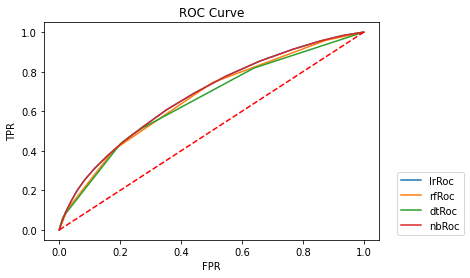

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

#rTrainingSummary = lrModel.summary
#rRoc             = lrTrainingSummary.roc.toPandas()

#lt.plot(lrRoc['FPR'],  lrRoc['TPR'],  label = 'lrRoc')
plt.plot(fpr_lr_values, tpr_lr_values, label = 'lrRoc')
plt.plot(fpr_rf_values, tpr_rf_values, label = 'rfRoc')
plt.plot(fpr_dt_values, tpr_dt_values, label = 'dtRoc')
plt.plot(fpr_nb_values, tpr_nb_values, label = 'nbRoc')

plt.plot([0,1], [0,1], 'r--')

plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('ROC Curve')
plt.legend(bbox_to_anchor=(1.04,0), loc = 'lower left')
plt.show()

### Extracting Important Features
Lets us look at what features are the most important when it comes to decising our models

In [ ]:
import pandas as pd

def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []

    for i in dataset.schema[featuresCol].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]

    varlist          = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    return(varlist.sort_values('score', ascending = False))


In [ ]:
ExtractFeatureImp(rfModel.featureImportances,rfPredictions, 'features').head(10)

,idx,name,score
38,25,speedZoneDesc_vec_100 km/h,0.131182
100,87,driverAgeGroup_vec_70+,0.115115
53,40,vehicleTypeDesc_vec_Car,0.098076
23,10,lightConditionDesc_vec_Dark No street lights,0.090000
74,61,trafficControlDesc_vec_No control,0.073262
12,194,vehicleYearManuf,0.063194
20,7,lightConditionDesc_vec_Day,0.058472
36,23,speedZoneDesc_vec_60 km/h,0.055211
27,14,roadGeometryDesc_vec_Not at intersection,0.044211
41,28,speedZoneDesc_vec_40 km/h,0.023720


In [ ]:
ExtractFeatureImp(dtModel.featureImportances,dtPredictions, 'features').head(10)

,idx,name,score
38,25,speedZoneDesc_vec_100 km/h,0.319363
12,194,vehicleYearManuf,0.231337
100,87,driverAgeGroup_vec_70+,0.209082
20,7,lightConditionDesc_vec_Day,0.142643
23,10,lightConditionDesc_vec_Dark No street lights,0.050708
22,9,lightConditionDesc_vec_Dusk/Dawn,0.024356
110,97,LGAName_vec_MONASH,0.010731
53,40,vehicleTypeDesc_vec_Car,0.004439
27,14,roadGeometryDesc_vec_Not at intersection,0.002453
113,100,LGAName_vec_HUME,0.001387


### Hyperparameter tuning

In [ ]:
from pyspark.ml.tuning     import ParamGridBuilder, CrossValidator,CrossValidatorModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [ ]:
pipelineModel.stages[-1].extractParamMap()

{Param(parent='VectorAssembler_a473ecde8d39', name='outputCol', doc='output column name.'): 'features',
 Param(parent='VectorAssembler_a473ecde8d39', name='handleInvalid', doc="How to handle invalid data (NULL and NaN values). Options are 'skip' (filter out rows with invalid data), 'error' (throw an error), or 'keep' (return relevant number of NaN in the output). Column lengths are taken from the size of ML Attribute Group, which can be set using `VectorSizeHint` in a pipeline before `VectorAssembler`. Column lengths can also be inferred from first rows of the data since it is safe to do so but only in case of 'error' or 'skip')."): 'error',
 Param(parent='VectorAssembler_a473ecde8d39', name='inputCols', doc='input column names.'): ['dayOfWeekDesc_vec',
  'lightConditionDesc_vec',
  'roadGeometryDesc_vec',
  'speedZoneDesc_vec',
  'roadSurfaceTypeDesc_vec',
  'vehicleTypeDesc_vec',
  'trafficControlDesc_vec',
  'driverSex_vec',
  'driverAgeGroup_vec',
  'LGAName_vec',
  'dust',
  'fog'

In [ ]:
# Define an evaluator to be used for evaluating the model
rfevaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

In [ ]:
# Re-define pipeline for grid search algorithm
stage_4 = rf
stages = [stage_1,stage_2,stage_3, stage_4]

pipeline = Pipeline(stages = stages)

train, test = AccidentFinal.randomSplit([0.8, 0.2], seed = 2020)

#### Grid search via Cross Validation

In [ ]:
# Create ParamGrid for Cross Validation
rfparamGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [10,  15, 20])
             .addGrid(rf.numTrees, [25, 30])
             .build())

In [ ]:
# Create 3-fold CrossValidator
rfcv = CrossValidator(
    estimator          = pipeline,
    estimatorParamMaps = rfparamGrid,
    evaluator          = rfevaluator,
    numFolds           = 3,
    parallelism        = 4)

In [ ]:
# Run cross validations
rfcvModel = rfcv.fit(train)
print(rfcvModel)

CrossValidatorModel_e54e111c7127


In [ ]:
#Getting the best model and the optimum parameters selected from the Cross Validation
bestRfModel= rfcvModel.bestModel
print(bestRfModel.stages)
print('Best Param for Random Forest: ', bestRfModel.stages[-1]._java_obj.paramMap())

[StringIndexerModel: uid=StringIndexer_a7fd664c8a05, handleInvalid=keep, numInputCols=11, numOutputCols=11, OneHotEncoderModel: uid=OneHotEncoder_58419c4376a2, dropLast=true, handleInvalid=error, numInputCols=10, numOutputCols=10, VectorAssembler_a473ecde8d39, RandomForestClassificationModel: uid=RandomForestClassifier_d3ef7606c1bb, numTrees=30, numClasses=3, numFeatures=195]
Best Param for Random Forest:  {
	RandomForestClassifier_d3ef7606c1bb-featuresCol: features,
	RandomForestClassifier_d3ef7606c1bb-labelCol: label,
	RandomForestClassifier_d3ef7606c1bb-maxDepth: 20,
	RandomForestClassifier_d3ef7606c1bb-numTrees: 30,
	RandomForestClassifier_d3ef7606c1bb-seed: 2020
}


In [ ]:
bestRfPredict = bestRfModel.transform(test)

In [ ]:
compute_metrics(bestRfPredict)

-------------------------
Predict    Label   Count
-------------------------
   0         0     16831
   1         1     15008
   0         1     7767
   1         0     6408


Accuracy : 0.692
Precision: 0.701
Recall   : 0.659
F1       : 0.679


(0.6919415829964793,
 0.7007844602166604,
 0.6589681668496158,
 0.6792333280532235)

In [ ]:
# Extract the important feature of the best model - top 10
ExtractFeatureImp(bestRfModel.stages[-1].featureImportances,bestRfPredict, 'features').head(10)

,idx,name,score
12,194,vehicleYearManuf,0.115466
37,24,speedZoneDesc_vec_100 km/h,0.076384
100,87,driverAgeGroup_vec_70+,0.059878
23,10,lightConditionDesc_vec_Dark No street lights,0.037096
20,7,lightConditionDesc_vec_Day,0.036200
53,40,vehicleTypeDesc_vec_Car,0.032515
74,61,trafficControlDesc_vec_No control,0.025818
36,23,speedZoneDesc_vec_60 km/h,0.021287
21,8,lightConditionDesc_vec_Dark Street lights on,0.020580
27,14,roadGeometryDesc_vec_Not at intersection,0.018552


In [ ]:
# Extract the important feature of the best model - top 25
ExtractFeatureImp(bestRfModel.stages[-1].featureImportances,bestRfPredict, 'features').head(25)

,idx,name,score
12,194,vehicleYearManuf,0.115466
37,24,speedZoneDesc_vec_100 km/h,0.076384
100,87,driverAgeGroup_vec_70+,0.059878
23,10,lightConditionDesc_vec_Dark No street lights,0.037096
20,7,lightConditionDesc_vec_Day,0.036200
53,40,vehicleTypeDesc_vec_Car,0.032515
74,61,trafficControlDesc_vec_No control,0.025818
36,23,speedZoneDesc_vec_60 km/h,0.021287
21,8,lightConditionDesc_vec_Dark Street lights on,0.020580
27,14,roadGeometryDesc_vec_Not at intersection,0.018552


# Sample Data Testing
Testing the pipline to input new data (for example if there was 2021 data) to show that the model can be used for new data.   To simulate this we are using the original datafile and sampling rows at random to simulate this.

### Create Sample Data

In [ ]:
AccidentSample = []
#Load AccidentFinal Data
# Read in the accident data as dataframe
AccidentSample = spark.read.format('csv')\
                     .option('header',True)\
                     .option('escape','"')\
                     .option('inferSchema',True)\
                     .load('AccidentFinal.csv')

### Feature Engineering

In [ ]:
# Sample the data with 10 rows
sample_Data , sample_Notinuse = AccidentSample.randomSplit([0.00002, 0.99998], seed = 20)
sample_Data.count()

11

In [ ]:
# Create function to convert variable
y_udf = udf(lambda y: 1 if y == '1' or y == '2' else 0)
# Apply user defined function and drop old column
sample_Data = sample_Data.withColumn('severeAccident', y_udf('maxInjuryLevel')).drop('maxInjuryLevel')

In [ ]:
## Dropping Columns
sample_Data = sample_Data.drop('accidentDate','accidentTime', 'DCACode', 'numVehicles',
                                   'numPersons','numPersonsInj2', 'numPersonsInj3', "speedZone",
                                   'numPersonsKilled', 'numPersonsNotInj', 'accidentDateOnly', 'accidentTimeOnly',
                                   'accidentDateTime', 'roadSurfaceType', 'driverAge', 'trafficControl', 'vehicleType',
                                   'fuelType','traffic Control','regionName','postCode','nodeTypeDesc',
                                   'accidentSeverityDesc', 'accidentSeverity', 'totalNoOccupants', 'DCADescription',
                                  'isPedestrian', 'vehicleMovement', 'eventTypeDesc', 'accidentTypeDesc',
                                   'levelOfDamage',
                                  )

In [ ]:
# Change data type
sample_Data = sample_Data.withColumn ("dust", sample_Data.dust.cast("Int"))\
                             .withColumn ("fog", sample_Data.fog.cast("Int") )\
                             .withColumn ("raining", sample_Data.raining.cast("Int") )\
                             .withColumn ("smoke", sample_Data.smoke.cast("Int") )\
                             .withColumn ("snowing", sample_Data.snowing.cast("Int") )\
                             .withColumn ("strongWinds", sample_Data. strongWinds.cast("Int") ) \
                             .withColumn ("icy", sample_Data.icy.cast("Int") )\
                             .withColumn ("muddy", sample_Data.muddy.cast("Int") )\
                             .withColumn ("snowy", sample_Data.snowy.cast("Int") )  \
                             .withColumn ("wet", sample_Data.wet.cast("Int") )\
                             .withColumn ("dry", sample_Data.dry.cast("Int") ) \
                             .withColumn ("clear", sample_Data.clear.cast("Int") )\
                             .withColumn ("vehicleYearManuf", sample_Data.vehicleYearManuf.cast("Int"))\
                             .withColumn ("severeAccident", sample_Data.severeAccident.cast("Int"))\
                             .cache()

In [ ]:
#Remove rows with Null value
#sample_Data = AccidentSample.na.drop()

In [ ]:
# Display all data
sample_Data.show(vertical=True)

-RECORD 0-----------------------------------
 dayOfWeekDesc       | Wednesday            
 lightConditionDesc  | Day                  
 roadGeometryDesc    | Cross intersection   
 speedZoneDesc       | 50 km/h              
 dust                | 0                    
 fog                 | 0                    
 raining             | 0                    
 smoke               | 0                    
 snowing             | 0                    
 strongWinds         | 0                    
 icy                 | 0                    
 muddy               | 0                    
 snowy               | 0                    
 wet                 | 0                    
 dry                 | 1                    
 clear               | 1                    
 vehicleYearManuf    | 2012                 
 roadSurfaceTypeDesc | Paved                
 vehicleTypeDesc     | Station Wagon        
 trafficControlDesc  | Giveway sign         
 driverSex           | F                    
 driverAge

### Run Pipeline + Random Forest Model

In [ ]:
# Predict using sample data and Best Random Forest Model developed with cross validation
rfSamplePredictions = bestRfModel.transform(sample_Data)
rfSamplePredictions.select('features','label','prediction','probability').show()

+--------------------+-----+----------+--------------------+
|            features|label|prediction|         probability|
+--------------------+-----+----------+--------------------+
|(195,[2,7,15,26,3...|  0.0|       0.0|[0.72657387732322...|
|(195,[4,7,15,26,3...|  0.0|       0.0|[0.74779606490603...|
|(195,[3,7,14,24,3...|  0.0|       1.0|[0.29268007600882...|
|(195,[3,7,14,26,3...|  0.0|       0.0|[0.74293724215331...|
|(195,[1,10,14,26,...|  1.0|       1.0|[0.36328143852638...|
|(195,[3,8,15,27,3...|  0.0|       0.0|[0.51256283272331...|
|(195,[5,7,14,25,3...|  0.0|       0.0|[0.63193620813397...|
|(195,[5,7,16,23,3...|  0.0|       0.0|[0.72920756912731...|
|(195,[2,7,15,27,3...|  0.0|       0.0|[0.72672167479979...|
|(195,[5,8,15,23,3...|  0.0|       1.0|[0.45005047288854...|
|(195,[6,7,14,23,3...|  0.0|       0.0|[0.78802409641955...|
+--------------------+-----+----------+--------------------+



In [ ]:
# Display Prediction results
rfSamplePredictions.show(vertical =True)

-RECORD 0-----------------------------------------
 dayOfWeekDesc             | Wednesday            
 lightConditionDesc        | Day                  
 roadGeometryDesc          | Cross intersection   
 speedZoneDesc             | 50 km/h              
 dust                      | 0                    
 fog                       | 0                    
 raining                   | 0                    
 smoke                     | 0                    
 snowing                   | 0                    
 strongWinds               | 0                    
 icy                       | 0                    
 muddy                     | 0                    
 snowy                     | 0                    
 wet                       | 0                    
 dry                       | 1                    
 clear                     | 1                    
 vehicleYearManuf          | 2012                 
 roadSurfaceTypeDesc       | Paved                
 vehicleTypeDesc           | St